# Snake Charge Scan

To manipulate an electron confined by gate-defined quantum dot, it is essential to control the number of electron i.e. the chemical potential of each quantum dot and the tunnel coupling among quantum dots. The charge stability diagram (CSD) represents electrostatic characteristics of such a quantum dot system for a give charge configuration which suggests the operation point and the work window for further experiements. However, the CSD depends on the sweep direction of gate voltages thus a charge state hysteresis in quantum dots has been observed and inverstigated. [1]

[1] C. H. Yang, et al., Appl. Phys. Lett. 105, 183505 (2014)

In this tutorial, a pulse for the bi-directional sweep of a CSD is constructed so that the hysteresis of charge occupancy in a double quantum dot system can be measured. For ease of analysis, 2 different measurement windows namingly `('x_neg', 'x_pos')` are defined providing the possibliy of inspecting two sweep direction individually. Options of `plot` function in `qupulse.pulses.plotting` will be explored as well.

TODO: add some figures here...

#### Task 1: Piece-wised voltage level

> Description: Let 2 AWG channels `(X, Y)` hold at a given set of voltages `(x_start, y_start)` for specific time durations `t_hold`.

Firtly, we build a piece of voltage level with free parameters 't_hold' and 'sample_rate' representing the time duration of such voltage level and the sample rate of AWG, respectively. With aforementioned parameters, a universal piece-wised pulse can be used as a building block of most experiments with flexibility of adjusting the pulse duration and hardward settings i.e. the sample rate of AWG.

TODO: use ConstantPT instead of PointPT of segments.

TODO: make building blocks and different tasks

In [5]:
import sympy
from qupulse.pulses import ConstantPT, RepetitionPT

sample_rate, n_segments, t_hold = sympy.sympify('sample_rate, n_segments, t_hold')
t_segment = n_segments / sample_rate

segment = ConstantPT(t_segment, {'X': 'x_start + x_i * x_step', 
                                 'Y': 'y_start + y_i * y_step'}
                    )
body = RepetitionPT(segment, t_hold // t_segment, measurements=[('M', 0, 't_hold')])

In [6]:
print(segment.defined_channels)
print(segment.integral)

dict_keys(['X', 'Y'])
{'X': ExpressionScalar('n_segments*(x_i*x_step + x_start)/sample_rate'), 'Y': ExpressionScalar('n_segments*(y_i*y_step + y_start)/sample_rate')}


In [7]:
print(body.defined_channels)
print(body.integral)


dict_keys(['X', 'Y'])
{'X': ExpressionScalar('n_segments*(x_i*x_step + x_start)*floor(sample_rate*t_hold/n_segments)/sample_rate'), 'Y': ExpressionScalar('n_segments*(y_i*y_step + y_start)*floor(sample_rate*t_hold/n_segments)/sample_rate')}


Now that a piece of voltage level is constructed with given voltages

A charge stability diagram can be abstracted by a nested for loop using `ForLoopPT` in qupulse. In order to define the name of measurement window for different sweep direction, the `ForLoopPT` is wrapped by a `MappingPT`.

The voltage resolution of the scan is described by `{x_step, y_step}` which are converted by qupulse according to the user inputs `{x_start, x_stop, N_x, y_start, y_stop, N_y}` representing the start voltage and stop voltages on different scan axis and the number of voltage levels of each axes.

In [8]:
from qupulse.pulses import MappingPT, ForLoopPT
print(type(body.measurement_names))
print(type(body.measurement_parameters))

test = ForLoopPT(body, 'x_i', 'N_x')


<class 'set'>
<class 'set'>


TypeError: descriptor 'union' requires a 'set' object but received a 'frozenset'

---
Below were successfully constructed by using `PointPT` instead of `ConstantPT`...

In [ ]:


inner_loop_fwd = MappingPT(ForLoopPT(body, 'x_i', 'N_x'), measurement_mapping={'M': 'x_pos'})
inner_loop_bwd = MappingPT(ForLoopPT(body, 'x_i', ('N_x - 1', -1, -1)), measurement_mapping={'M': 'x_neg'})
inner_loop = inner_loop_fwd @ inner_loop_bwd
outer_loop = ForLoopPT(inner_loop, 'y_i', 'N_y')
snake_sweep_seg = MappingPT(outer_loop, parameter_mapping={'x_step': '(x_stop - x_start) / (N_x - 1)',
                                                           'y_step': '(y_stop - y_start) / (N_y - 1)'})

In [7]:

snake_cds = MappingPT(snake_sweep_seg,
                      parameter_mapping={'t_hold': 'cds_res'},
                      identifier='Snake_CDS')
print(snake_cds.parameter_names)

{'n_segments', 'x_stop', 'x_start', 'y_start', 'N_x', 'sample_rate', 'y_stop', 'cds_res', 'N_y'}


Let's generate a pulse for a bi-directional charge scan with voltage resolution 0.3V/point on x-axis and 0.4V/point on y-axis.

In [8]:
default_params = {
    'n_segments': 1,
    'x_start': 0,
    'x_stop': 3,
    'y_start': 0,
    'y_stop': 2,
    'N_x': 10,
    'N_y': 5,
    'sample_rate': 1,
    'cds_res': 5
}

Now, we use `plot` function to inspect the positive sweep of channel X which is highlighted in the following plot.

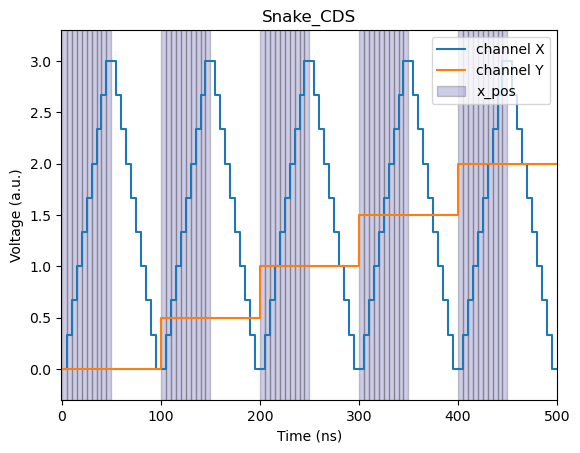

In [9]:
from qupulse.pulses.plotting import plot

_=plot(snake_cds, parameters=default_params, sample_rate=1, plot_measurements='x_pos')

Similaly the negative sweep is inspected by assigning the measurement window name `x_neg` to the input argument `plot_measurement` of `plot` function provided by qupulse.

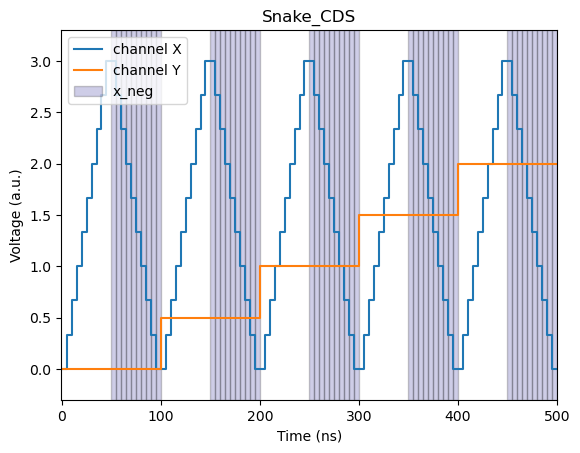

In [10]:
_=plot(snake_cds, parameters=default_params, sample_rate=1, plot_measurements='x_neg')